# Data Prep

This notebook is used for loading and preparing the data for modeling. 

It includes some simple exploration and visualization of the data, as well as the creation of the datasets for training and testing.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
import pickle

sentences = pd.read_csv('data/substance_interactions.csv')

## Load and Clean

I used only the `SUBJECT_TEXT`, `PREDICATE`, `OBJECT_TEXT`, and `SENTENCE` columns from the original dataset.

`SENTENCE` was very lightly processed - I just stripped extra whitespace.
I created a new `predication` column by concatenating the `SUBJECT_TEXT`, `PREDICATE`, and `OBJECT_TEXT` columns, and then cleaned it by replacing underscores with spaces and stripping extra whitespace.

I created a new column called `concatenated`, which contains the new `predication` column, a `[SEP]` token, and the `sentence` column. This will be the single input for our one-input model.

Finally, I shuffled the dataset (with a reproducible seed)

In [2]:
def create_predication(row):
    sentence = ' '.join([row.SUBJECT_TEXT, row.PREDICATE, row.OBJECT_TEXT])
    sentence = sentence.replace('_', ' ').lower()
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

def clean_target_sentences(text):
    text = re.sub(r'\s+', ' ', text)
    return text

sentences['predication'] = sentences.apply(create_predication, axis=1)
sentences['SENTENCE'] = sentences.apply(lambda x: clean_target_sentences(x.SENTENCE), axis=1)
sentences['sent_len'] = sentences.SENTENCE.str.len()

sentences = sentences.rename(columns={col: col.lower() for col in sentences.columns})
sentences = sentences[['sentence', 'predicate', 'predication', 'label', 'sent_len']]
sentences['concatenated'] = sentences.predication + '[SEP]' + sentences.sentence
sentences['label'] = sentences.label.map({'y': 1, 'n': 0})

# shuffle the dataframe
sentences = sentences.sample(frac=1, random_state=42).reset_index(drop=True)
sentences.head()

,sentence,predicate,predication,label,sent_len,concatenated
0,These results suggest that the elevation of pl...,INHIBITS,cbz-e inhibits epoxide hydrolase,0,178,cbz-e inhibits epoxide hydrolase[SEP]These res...
1,GABA affinity seemed to be identical to that o...,INTERACTS_WITH,beta 1 gamma 2 interacts with gaba,0,280,beta 1 gamma 2 interacts with gaba[SEP]GABA af...
2,The depressant effects of pressure-ejected NT ...,INTERACTS_WITH,6-ohda interacts with nt,1,165,6-ohda interacts with nt[SEP]The depressant ef...
3,As the hypoaminoacidaemic effect of insulin an...,INTERACTS_WITH,tyrosine interacts with glucagon,1,294,tyrosine interacts with glucagon[SEP]As the hy...
4,Some features of barbiturate interaction and i...,INTERACTS_WITH,nadh-cytochrome c oxidoreductase interacts wit...,1,113,nadh-cytochrome c oxidoreductase interacts wit...


# Inspect Dataset
Plot distribution of LABEL and PREDICATE in the dataset, along with the distribution of sentence lengths (in characters)

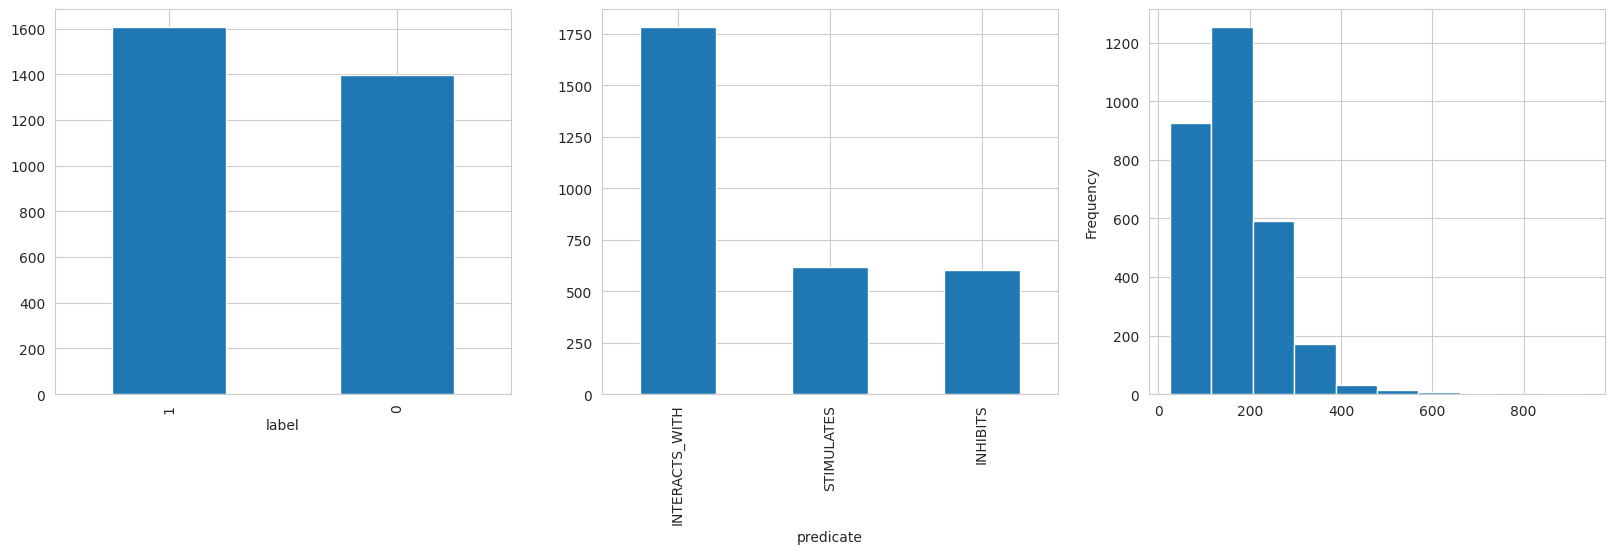

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sentences.label.value_counts().plot(kind='bar', ax=ax[0])
sentences.predicate.value_counts().plot(kind='bar', ax=ax[1])
sentences.sent_len.plot(kind='hist', ax=ax[2])
plt.show()

Check for Nulls

In [4]:
sentences.isnull().sum()

sentence        0
predicate       0
predication     0
label           0
sent_len        0
concatenated    0
dtype: int64

Do a sanity check to make sure there aren't wildly disproportionate predicates in the positive/negative labels

Text(0.5, 1.0, 'Predicate Distribution by Label')

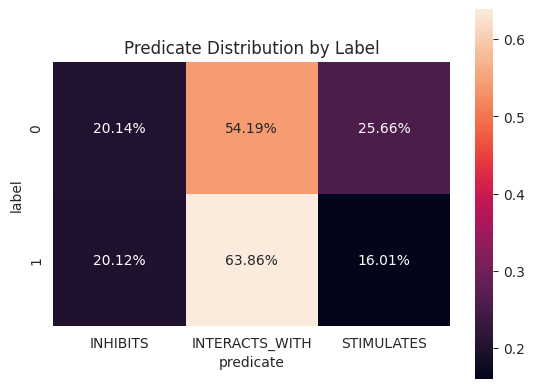

In [9]:
df = sentences.groupby(['label', 'predicate']).size().unstack()
df =df.div(df.sum(axis=1), axis=0)
g = sns.heatmap(df, annot=True, fmt='.2%', square=True)
g.get_figure().savefig('extras/data_prep_predicate_heatmap.png')
g.set_title('Predicate Distribution by Label')

# Build datasets

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

In [ ]:
dataset = {
    'sentence': {'text': sentences.sentence.values.tolist(),
                 'max_length': 250,},
    'predication': {'text': sentences.predication.values.tolist(),
                    'max_length': 32},
    'concatenated': {'text': sentences.concatenated.values.tolist(),
                     'max_length': 250},
    'predicate': {'text': sentences.predicate.values},
    'label': {'text': sentences.label.values}
}

test_size = 0.20

In [ ]:
test_size = int(len(sentences) * test_size)
train_size = int(len(sentences)-test_size)
test_size, train_size

for col in ['sentence', 'predication', 'concatenated']:
    dataset[col]['encoded'] = tokenizer.batch_encode_plus(dataset[col]['text'], max_length=dataset[col]['max_length'], padding='max_length', return_tensors='tf', truncation=True)['input_ids']
    dataset[col]['test']=dataset[col]['encoded'][0:test_size]
    dataset[col]['train']=dataset[col]['encoded'][test_size:]

for col in ['label', 'predicate']:
    dataset[col]['test']=dataset[col]['text'][0:test_size]
    dataset[col]['train']=dataset[col]['text'][test_size:]

# Save the datasets


In [ ]:
outfile = open('data/dataset.pkl', 'wb')
pickle.dump(dataset, outfile)
outfile.close()